# Tutorial

Jelle, October 2018

This notebook shows how to do basic high-level analysis with straxen, much like `hax.minitrees`.

For reference, here are some jargon terms which we will introduce below:

  * **Context**: Holds configuration on how to process
  * **Dataframe** or **array**: table of related information produced by a plugin.
  * **Plugin**: an algorithm that produces a dataframe
  * **Data type**: specification of which columns are in a dataframe. 
  * **Data kind**: e.g. 'events' or 'peaks'. Dataframes of the same kind  have the same number of rows and can be merged.


In [1]:
import numpy as np
# This just ensures some comments in dataframes below display nicely
import pandas as pd
pd.options.display.max_colwidth = 100

## Setting up

First we load a strax **context**, much like `hax.init()`. A strax context contains all information on *how* to process: where to read what files from, what plugins provide what data, etc. 

You can make a context yourselves using `strax.Context`, but straxen provides standardized contexts as well. Most future analyses will use such standardized contexts defined by analysis coordinators or straxen maintainers.

Unlike `hax.init`, you can have multiple active contexts, e.g. to load analysis and MC data, or compare data processed with different settings (we will see examples of this below).

In [2]:
import straxen
st = straxen.contexts.demo()

run_id = '180423_1022'

## Finding your data

Suposse we want to make a cS1/cS2 plot. We have to figure out which type of **dataframes** to load. A specific type of dataframe is also called a **data type**. (in hax these were called minitrees)

Unlike hax, we can find this out automatically:

In [3]:
st.search_field('cs1')

cs1 is part of corrected_areas (provided by CorrectedAreas)
cs1 is part of event_info (provided by EventInfo)


It seems we're after one of the data types called `event_info` or `corrected_areas`. In the current context, these are provided by **plugins** called EventInfo and CorrectedAreas, respectively (but this doesn't concern us yet). 

Let's see what else is in these data types:

In [4]:
st.data_info('corrected_areas')

,Field name,Data type,Comment
0,cs1,float32,Corrected S1 area (PE)
1,cs2,float32,Corrected S2 area (PE)


In [5]:
st.data_info('event_info')

,Field name,Data type,Comment
0,event_number,int64,Event number in this dataset
1,time,int64,Event start time in ns since the unix epoch
2,endtime,int64,Event end time in ns since the unix epoch
3,n_peaks,int32,Number of peaks in the event
4,drift_time,int64,Drift time between main S1 and S2 in ns
5,s1_index,int32,Main S1 peak index
6,s1_area,float32,"Main S1 area (PE), uncorrected"
7,s1_area_fraction_top,float32,Main S1 area fraction top
8,s1_range_50p_area,float32,"Main S1 width (ns, 50% area)"
9,s1_n_competing,int32,Main S1 number of competing peaks


As you can see, `event_info` has a lot more information; let's load that one. You can see from the documentation (TODO link) that `event_info`'s job is to merge the info from `corrected_areas` and other things.


## Loading data

The first time you run this it will take a moment: it has to actually process the data somewhat. We didn't ship highest-level demo data with straxen: that would mean we'd have to constantly update the test data when the algorithms change.

In [6]:
df = st.get_df(run_id, 'event_info')

Just like hax.minitrees.load, we got a dataframe back. At the moment you can only load one run at a time (but of course this should change).

Though it's not related to strax, let's make a quick plot of the events we just loaded:

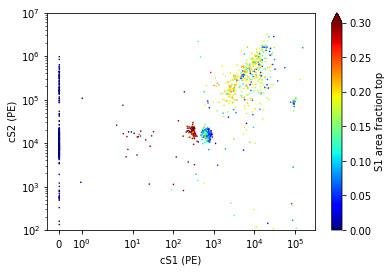

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def event_plot(df):
    plt.scatter(df.cs1, df.cs2,
                c=df.s1_area_fraction_top,
                vmin=0, vmax=0.3, 
                s=10,
                cmap=plt.cm.jet,
                marker='.', edgecolors='none')
    plt.colorbar(label="S1 area fraction top", extend='max')
    plt.xlabel('cS1 (PE)')
    plt.ylabel('cS2 (PE)')
    plt.xscale('symlog')
    plt.yscale('log')
    plt.ylim(1e2, 1e7)
    
event_plot(df)

Can you figure out what kind of data this is?

## Waveform analysis

Currently strax does not have a dedicated waveform plotter yet. However, a key feature is that the *peaks* array contains the sum waveform information:

In [8]:
st.data_info('peaks')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,float32,Integral across channels in photoelectrons
5,area_per_channel,"('<i4', (260,))",Integral per channel in ADX x samples (not PE!)
6,n_hits,int16,Number of hits from which peak was constructed (currently zero if peak is split afterwards)
7,data,"('<f4', (200,))",Waveform data in PE/sample (not PE/ns!)
8,width,"('<f4', (11,))",Peak widths in ns: range of central area fraction
9,saturated_channel,"('<i2', (260,))",Check if channel is saturated


Notice the compound data type of the `data` field and two others (`area_per_channel` and `width`). While we could load this data with get_df, pandas DataFrames which such fields are very inefficient. A better datastructure is numpy arrays:

In [9]:
peaks = st.get_array(run_id, 'peaks')
type(peaks), peaks.dtype.names

(numpy.ndarray,
 ('channel',
  'dt',
  'time',
  'length',
  'area',
  'area_per_channel',
  'n_hits',
  'data',
  'width'))

Now we can plot peak waveforms:

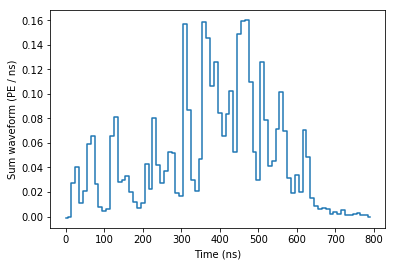

In [10]:
def plot_peak(p, t0=None, **kwargs):
    n = p['length']
    if t0 is None:
        t0 = p['time']
    plt.plot((p['time'] - t0) + np.arange(n) * p['dt'], 
             p['data'][:n] / p['dt'], 
             linestyle='steps-mid',
             **kwargs)
    plt.xlabel("Time (ns)")
    plt.ylabel("Sum waveform (PE / ns)")

plot_peak(peaks[2000])

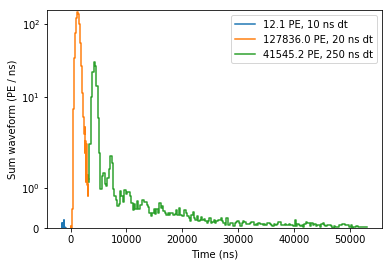

In [11]:
def plot_peaks(main_i, n_before=0, n_after=0, label_threshold=0):
    for i in main_i + np.arange(-n_before, n_after + 1):
        p = peaks[i]
        label = None
        if p['area'] > label_threshold:
            label = '%.1f PE, %d ns dt' % (p['area'], p['dt'], )
        plot_peak(p,
                  t0=peaks[main_i]['time'],
                  label=label)
    plt.ylim(0, None)
    plt.legend(loc='upper right')
    plt.yscale('symlog')

plot_peaks(943, n_after=1, n_before=1)

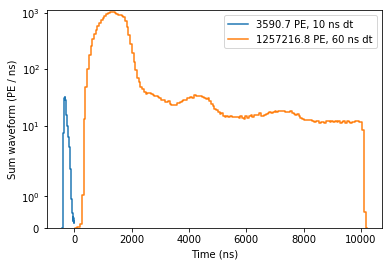

In [12]:
plot_peaks(1190, n_after=0, n_before=1, label_threshold=50)
plt.show()

The abrupt termination of the S2 above is due to strax's data reduction.

## Configuration changes

### Motivation

The following was just as easy as loading data with `hax.minitrees`. However, strax also makes some things that were very difficult with pax/hax easy too. 

As you can see in the above plot, we have many events high up in the TPC at low S1. Perhaps you might want to get rid of them by increasing the 'S1 coincidence requirement', i.e. the number of PMTs that must see something before a peak is labeled as S1. Then, of course, you want to load the event-level data again to see if it worked.

#### How it works in pax/hax

 * Find out which plugin does S1 classification (search on github?)
 * Look at source code to see what options it takes
 * Make custom ini or at least `--config_str` option (look up syntax)
 * Either
   * Download raw data from rucio (zzzz...)
   * Reprocess data with pax from scratch (look up syntax)
 * Or: 
   * Do partial reprocessing, if you can figure out what fields you can load from ROOT file and what plugins are safe to run, then make custom ini that does that, etc...
 * Point hax to folder with results (using `hax.init`) and figure out how to get hax to ignore the runs db (`pax_version_policy`? `use_run_db`?)
 * (couple retries because we rely on undocumented file naming conventions to figure out if data exists)
 * Use hax.load to remake the minitrees you want.


### How it works in strax

First, we need to see which configuration option we have to change. Since strax plugins declare explicitly what configuration they take and what other plugins they depend on, this can be done automatically. We just ask which options with `s1` in their name influence `event_basics`:

In [13]:
st.show_config('event_basics', 's1*')

,option,default,current,applies_to,help
0,s1_max_width,150,<OMITTED>,peak_classification,Maximum (IQR) width of S1s
1,s1_min_n_channels,3,<OMITTED>,peak_classification,Minimum number of PMTs that must contribute to a S1


Looks like we're after the `s1_min_n_channels option`. Note this is not part of the `event_basics` data type, but of a data type called `peak_classification`. As you can see from the table, this option is not set in the current context, so the default value (3) is used.

To try out a different option, just pass it to get_df:

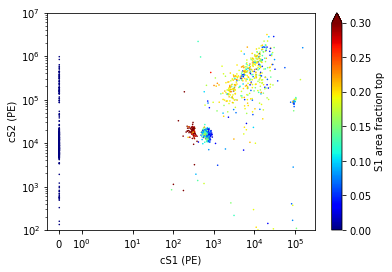

In [14]:
df_2 = st.get_df(run_id, 'event_info',
                 config=dict(s1_min_n_channels=50))
event_plot(df_2)

Notice all the small S1 events are indeed gone now.

Behind the scenes, this figured out which dataframes had to be remade: as it happens this time just `event_basics` and `peak_basics`. You will now have a new `event_basics_<somehash>` folder in `./custom_data` which contains the results, as well as a new `peak_basics_<somehash> folder`.

### More on configuration changes

Changing configuration can be done in two other ways. We can change it permanently in the current context:

    st.set_config(dict(s1_min_channels=50))
    
Or we could make a new context, with this option set:
    
    st_2 = st.new_context(config=dict(s1_min_channels=50))
    
(feeding it to get_df just does the latter behind the scenes).

Strax also protects you from typos in the configuration. Suppose we typed `s1_min_n_channelz` instead:

/home/aalbers/software/strax/strax/context.py:314: UserWarning: Option s1_min_n_channelz not taken by any registered plugin
  warnings.warn(f"Option {k} not taken by any registered plugin")


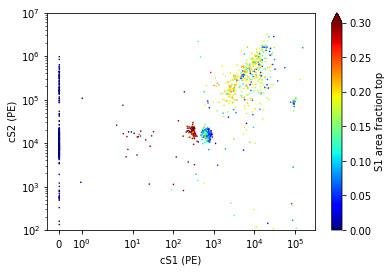

In [15]:
df_2 = st.get_df(run_id, 'event_info',
                 config=dict(s1_min_n_channelz=10))
event_plot(df_2)

The result of get_df is just the same as if the option wasn't set (just like in pax/hax), but you also get a warning about an unknown configuration option. 

## Heavy customization: new plugins

As it happens, changing the S1 coincidence requirement is not even configurable in pax, it's hardcoded:
  * https://github.com/XENON1T/pax/blob/master/pax/plugins/peak_processing/ClassifyPeaks.py#L29

Thus you have to do even more work: either install pax in developer mode, or write your own custom plugin, find out how to get pax to see it, change the config to use it, etc.

In hax you would make a custom minitree maker in this case. You can do the same with strax plugin.

Suppose you have a brilliant new idea for peak classification:

In [16]:
import strax
import numpy as np

class AdvancedExpertClassification(strax.Plugin):
    """Everything is an S1!"""
    provides = 'peak_classification'
    depends_on = ('peak_basics',)
    dtype = straxen.plugins.plugins.PeakClassification.dtype

    def compute(self, peaks):
        return dict(type=np.ones(len(peaks)))

[TODO: explain how to understand plugins like this. Also mention hax-like treemakers, see strax.xenon.plugins.LargestS2Area]

Notice the plugin provides 'peak_classification' and produces the same data type as PeakClassification plugin, which in this case is just:

In [17]:
AdvancedExpertClassification.dtype

[('type', numpy.int8, 'Classification of the peak.')]

To use it in place of PeakClassification, we only have to register it. Again, we can do so permanently using `st.register(AdvancedExpertClassification)` or temporarily by feeding it to `get_df`:

In [18]:
%%time
df = st.get_df(run_id, 'event_info',
               register=AdvancedExpertClassification)

CPU times: user 168 ms, sys: 302 ms, total: 470 ms
Wall time: 24.8 ms


In [19]:
df['s2_area'].max()

0.0

As you can see, all events are now S1-only events, as expected. Maybe this is not the best alternative classification :-)